# **In this project, I use the XGBoost Regressor model to predict calories burned based on features such as age, weight, heart rate, and body temperature.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
!pip install ydata_profiling

import ydata_profiling as ydp

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [ ]:
file_path = '/content/drive/MyDrive/Machine_Learning/Zjazd2/Praca domowa/calories_exercise_data.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()

,user_id,calories,gender,age,height,weight,duration,heart_rate,body_temp
0,14733363,231.0,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,66.0,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,26.0,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,71.0,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,35.0,female,27,154.0,58.0,10.0,81.0,39.8


In [ ]:
df.shape

(15000, 9)

# **DATA PREPROCESSING**

I generate a Profile Report to understand the dataset's distribution and identify missing values.

In [ ]:
diabetes_report = ydp.ProfileReport(df)
diabetes_report

Output hidden; open in https://colab.research.google.com to view.

Unnecessary columns ('user_id' and 'height') are removed.

In [ ]:
df = df.drop(['user_id', 'height'], axis=1)

In [ ]:
df.isna().sum()

,0
calories,0
gender,0
age,0
weight,0
duration,0
heart_rate,0
body_temp,0


Categorical variables like 'gender' are one-hot encoded into binary columns ('sex_female' and 'sex_male').

In [ ]:
df = pd.get_dummies(df, columns=['gender'], prefix=['sex'])

In [ ]:
df['sex_female'] = df['sex_female'].astype(int)
df['sex_male'] = df['sex_male'].astype(int)

The 'duration' column is binned into ranges (e.g., 0-10, 10-20) to capture non-linear relationships and reduce noise, then one-hot encoded.

In [ ]:
# Define the bin edges
bin_edges = [0, 10, 20, 30, 40, 50, float('inf')]  # Example bins: 0-10, 10-20, ..., 50+

# Define bin labels (optional)
bin_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50+']

# Use pd.cut to create the bins
df['duration_bins'] = pd.cut(df['duration'], bins=bin_edges, labels=bin_labels, right=False)

In [ ]:
# Perform one-hot encoding on the 'duration_bins' column
df = pd.get_dummies(df, columns=['duration_bins'], drop_first=True)

The 'duration' column is dropped after binning.

In [ ]:
df = df.drop(['duration'], axis=1)

In [ ]:
df.head()

,calories,age,weight,heart_rate,body_temp,sex_female,sex_male,duration_bins_10-20,duration_bins_20-30,duration_bins_30-40,duration_bins_40-50,duration_bins_50+
0,231.0,68,94.0,105.0,40.8,0,1,False,True,False,False,False
1,66.0,20,60.0,94.0,40.3,1,0,True,False,False,False,False
2,26.0,69,79.0,88.0,38.7,0,1,False,False,False,False,False
3,71.0,34,71.0,100.0,40.5,1,0,True,False,False,False,False
4,35.0,27,58.0,81.0,39.8,1,0,True,False,False,False,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   calories             15000 non-null  float64
 1   age                  15000 non-null  int64  
 2   weight               15000 non-null  float64
 3   heart_rate           15000 non-null  float64
 4   body_temp            15000 non-null  float64
 5   sex_female           15000 non-null  int64  
 6   sex_male             15000 non-null  int64  
 7   duration_bins_10-20  15000 non-null  bool   
 8   duration_bins_20-30  15000 non-null  bool   
 9   duration_bins_30-40  15000 non-null  bool   
 10  duration_bins_40-50  15000 non-null  bool   
 11  duration_bins_50+    15000 non-null  bool   
dtypes: bool(5), float64(4), int64(3)
memory usage: 893.7 KB


# **MODEL PREPARATION**

The features (X) and target variable (y) are separated.
The data is split into training and test sets (70%/30%).

In [ ]:
X = df.drop('calories', axis=1)
y = df['calories']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# **NORMALIZATION**

MinMaxScaler is applied to normalize continuous variables like age, weight, heart_rate, and body_temp.

In [ ]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Columns to normalize
columns_to_normalize = ['age', 'weight', 'heart_rate', 'body_temp']

# Fit the scaler on the training data and transform the specified columns
X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])

# Transform the test set using the scaler fitted on the training set
X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

In [ ]:
# Display the scaled datasets
print("Normalized Training Data:")
print(X_train.head())

print("\nNormalized Test Data:")
print(X_test.head())

Normalized Training Data:
            age    weight  heart_rate  body_temp  sex_female  sex_male  \
11797  0.593220  0.541667    0.196721   0.340909           0         1   
5899   0.338983  0.802083    0.508197   0.704545           0         1   
9513   0.457627  0.343750    0.540984   0.750000           1         0   
1572   0.203390  0.500000    0.655738   0.863636           0         1   
12995  0.152542  0.583333    0.295082   0.431818           0         1   

       duration_bins_10-20  duration_bins_20-30  duration_bins_30-40  \
11797                False                False                False   
5899                 False                 True                False   
9513                  True                False                False   
1572                 False                 True                False   
12995                False                False                False   

       duration_bins_40-50  duration_bins_50+  
11797                False              False  


# **TUNING HYPERPARAMETERS, MODEL TRAINING AND PREDICTION**

A RandomizedSearchCV is used to find the optimal hyperparameters for the XGBoost model, with parameters like max_depth, n_estimators, learning_rate, and gamma.

In [ ]:
# Define the parameter grid
params = {
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Add learning rate for flexibility
    'gamma': [0, 0.1, 0.2, 0.5],  # Add gamma to control regularization
    'lambda': [0.1, 1, 10],
    'min_child_weight': [1, 3, 5]  # Optional, related to min_samples_leaf
}

In [ ]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=params,
    scoring='neg_mean_absolute_error',  # Mean Absolute Error as the metric
    n_iter=5,  # Number of random samples
    cv=3,  # Cross-validation folds
    verbose=2,  # Output progress
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the search
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'gamma': [0, 0.1, 0.2, 0.5],
                                        'lambda': [0.1, 1, 10],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

The model is trained with the best hyperparameters, and predictions are made on the test set.
Mean Absolute Error (MAE) is calculated to evaluate performance, and a scatter plot of actual vs. predicted calories is visualized.

In [ ]:
# Get the best model
best_xgb_model = random_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Train the model with the best parameters
best_xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_xgb_model.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Best parameters found:  {'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.2, 'lambda': 10, 'gamma': 0.2}
Mean Absolute Error: 8.062795793472064


# **MODEL EVALUATION**

Additional metrics such as MSE, RMSE, R² score, and Explained Variance Score are calculated to assess model accuracy and robustness.

In [ ]:
mae_train = mean_absolute_error(y_train, random_search.predict(X_train))
mae_test = mean_absolute_error(y_test, random_search.predict(X_test))

from sklearn.metrics import r2_score
r2_train = r2_score(y_train, random_search.predict(X_train))
r2_test = r2_score(y_test, random_search.predict(X_test))

from sklearn.metrics import mean_squared_error
rmse_train = mean_squared_error(y_train, random_search.predict(X_train), squared=False)
rmse_test = mean_squared_error(y_test, random_search.predict(X_test), squared=False)

mse_train = mean_squared_error(y_train, random_search.predict(X_train))
mse_test = mean_squared_error(y_test, random_search.predict(X_test))

from sklearn.metrics import median_absolute_error
medae_train = median_absolute_error(y_train, random_search.predict(X_train))
medae_test = median_absolute_error(y_test, random_search.predict(X_test))

from sklearn.metrics import explained_variance_score
evs_train = explained_variance_score(y_train, random_search.predict(X_train))
evs_test = explained_variance_score(y_test, random_search.predict(X_test))

print(f"Training MAE: {mae_train}")
print(f"Test MAE: {mae_test}")
print(f"Training MSE: {mse_train}")
print(f"Test MSE: {mse_test}")
print(f"Training RMSE: {rmse_train}")
print(f"Test RMSE: {rmse_test}")
print(f"Training R²: {r2_train}")
print(f"Test R²: {r2_test}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training MAE: 7.515653027494216
Test MAE: 8.062795793472064
Training MSE: 103.96246444891945
Test MSE: 120.32497927586282
Training RMSE: 10.196198529300979
Test RMSE: 10.969274327678328
Training R²: 0.973203121304461
Test R²: 0.969517993670791


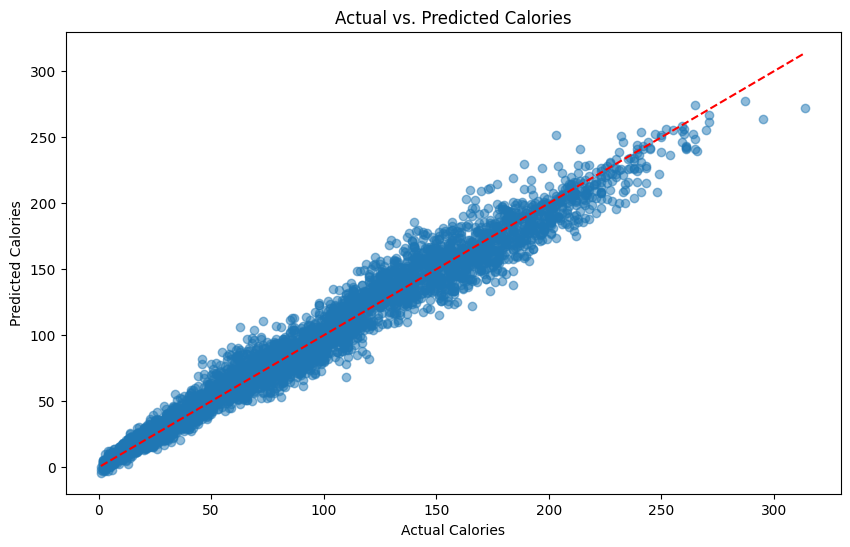

In [ ]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories")
plt.title("Actual vs. Predicted Calories")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') # Add a diagonal line
plt.show()

# **VERIFICATION**

In [ ]:

new_data = pd.DataFrame({
    'age': [25],  # Replace with actual age
    'weight': [100], # Replace with actual weight
    'heart_rate': [120], # Replace with actual heart rate
    'body_temp': [37], # Replace with actual body temperature
    'sex_female': [0],  # Replace with 0 or 1 (female or male)
    'sex_male': [1],
    'duration_bins_10-20': [0], # Example bin - adjust based on duration
    'duration_bins_20-30': [0],
    'duration_bins_30-40': [0],
    'duration_bins_40-50': [1],
    'duration_bins_50+': [0]
})

# Normalize the new data
columns_to_normalize = ['age', 'weight', 'heart_rate', 'body_temp']
new_data[columns_to_normalize] = scaler.transform(new_data[columns_to_normalize])


# Predict the calories
predicted_calories = best_xgb_model.predict(new_data)

print(f"Predicted Calories: {predicted_calories[0]}")

Predicted Calories: 113.75980377197266
